In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
%config InlineBackend.figure_format = "retina"

import matplotlib
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath,amsfonts}')


In [3]:
fs = 15 # tick fontsize
fsL = fs + 3 # Latex fontsize
dpi = 300

## Coefficients

In [96]:
#need kappa_i big and kappa_u small
kappa_u = .1
kappa_i = .9 #baseline kappa_i = .9
k = 1
zeta = 1
phi_I = alpha_I = 0
phi_M = alpha_M = 0
eta_a  = 1
T = 1
N = 50
sigma_a = 20
eta_ZM =1
eta_ZP = 1
sigma_ZP = 10
sigma_ZM = 10
dt = T / N
batch_size = 100
nb_steps = 1_000
Z_bound = .6
S0 = 100
iter_banach = 20
f_i = 1
f_u = 1
c = 1
k = k*c
zeta = zeta*c
sigma_ZP = sigma_ZP * c
sigma_ZM = sigma_ZM * c
beta = 1 / (2 * k * (1 - k * kappa_u))
d = (1/(2*kappa_i)/(1+beta/(2*kappa_i)))  

## Study of the proportion of Informed/Uninformed traders

k = 1
kappa_i = .9
kappa_u = .1
f_i = 7
f_u = 4
beta = 1 / (2*k*f_u*(1-k*kappa_u))

In [97]:
print(beta)
print(beta*f_i)

0.5555555555555556
0.5555555555555556


In [98]:
def condition():
    term1 = 8 * T**2 * d**2 + 4 * T**2 * beta**2 * k**2 * d**2 + 4 * T**2 * d**2
    term2 = 8 * T**2 * d**2 * beta**2 * k**2 + 4 * T**2 * beta**2 * k**4 + 8 * T**2 * beta**4 * k**4 * d**2 + 8 * T**2 * beta**2 * k**2
    term3 = 16 * (phi_I)**2 * T**2 + 128 * (T**2 * (phi_I)**2 + (alpha_I)**2)
    term4 = 16 * (phi_M)**2 * T**2 + 128 * (T**2 * (phi_M)**2 + (alpha_M)**2)

    cond = max(term1, term2, term3, term4) < 1/4
    cond_dt = 1/(2*kappa_i)*beta < 1
    print(max(term1, term2, term3, term4),1/(2*kappa_i)*beta)
    return(cond,cond_dt)
print(condition())


4.286047053342651 0.308641975308642
(False, True)


In [99]:
def condition_v2():
    term1 = 6*T**2+2*beta**2
    term2 = 4*k**2*T**2 + 1/(2*kappa_i**2)
    term3 = 8*T**2*phi_I**2 + (64*(T**2*phi_M**2+alpha_M**2)/kappa_i**2 )
    term4 = 322*beta**2*T**2*phi_M**2 + 256*beta**2*k**2*(T**2*phi_M**2+alpha_M**2)
    cond = max(term1,term2,term3,term4) 
    return (cond,cond<1)    
print(condition_v2())

(6.617283950617284, False)


In [100]:
class ZNet(nn.Module):
    def __init__(self, input_dim, output_dim=1, hidden_dim=64):
        super(ZNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, y_I, y_M, q_I, q_M,z_plus,z_minus,alpha):
        xy = torch.cat([y_I, y_M, q_I, q_M,z_plus,z_minus,alpha], dim=1)
        return self.net(xy)

In [101]:
def simulate_trajectory(Q0_I,Q0_M, Y0_I,Y0_M,Z_nets, 
                        b_QI,b_QM,b_YI,b_YM, T, N, dW_S,dW_A,dW_ZP,dW_ZM):
    Q_I,Q_M, Y_I,Y_M, Z_vals_IS,Z_vals_IA,Z_vals_MS,Z_vals_MA,Z_vals_I_plus,Z_vals_I_minus,Z_vals_M_plus,Z_vals_M_minus,alpha,Z_plus,Z_minus=[Q0_I],[Q0_M], [Y0_I],[Y0_M],[],[],[],[],[],[],[],[], [torch.zeros(1, 1).expand(Q0_I.shape[0], -1)],[torch.zeros(1, 1).expand(Q0_I.shape[0], -1)],[torch.zeros(1, 1).expand(Q0_I.shape[0], -1)]

    for i in range(N):
        t = i * dt
        q_I,q_M, y_I,y_M,Alpha,ZP,ZM = Q_I[-1],Q_M[-1], Y_I[-1],Y_M[-1],alpha[-1],Z_plus[-1],Z_minus[-1]

        z_IS = Z_nets[0][i](y_I,y_M,q_I,q_M,ZP,ZM,Alpha)
        z_IA = Z_nets[1][i](y_I,y_M,q_I,q_M,ZP,ZM,Alpha)
        z_MS = Z_nets[2][i](y_I,y_M,q_I,q_M,ZP,ZM,Alpha)
        z_MA = Z_nets[3][i](y_I,y_M,q_I,q_M,ZP,ZM,Alpha)
        z_I_plus = Z_nets[4][i](y_I,y_M,q_I,q_M,ZP,ZM,Alpha)
        z_I_minus = Z_nets[5][i](y_I,y_M,q_I,q_M,ZP,ZM,Alpha)
        z_M_plus = Z_nets[6][i](y_I,y_M,q_I,q_M,ZP,ZM,Alpha)
        z_M_minus = Z_nets[7][i](y_I,y_M,q_I,q_M,ZP,ZM,Alpha)
        
        Z_vals_IS.append(z_IS)
        Z_vals_IA.append(z_IA)
        Z_vals_MS.append(z_MS)
        Z_vals_MA.append(z_MA)
        Z_vals_I_plus.append(z_I_plus)
        Z_vals_I_minus.append(z_I_minus)
        Z_vals_M_plus.append(z_M_plus)
        Z_vals_M_minus.append(z_M_minus)
        
        dWt_S = dW_S[:, i, :]
        dWt_A = dW_A[:, i, :]
        dWt_ZP = dW_ZP[:,i,:]
        dWt_ZM = dW_ZM[:,i,:]
        
        nu_plus,nu_minus = nu(y_I,y_M,ZP,ZM)
        delta_plus,delta_minus= delta(nu_plus,nu_minus,ZP,ZM,y_M)
        
      
        q_I_next = q_I + b_QI(nu_plus,nu_minus) * dt 
        q_M_next = q_M + b_QM(nu_plus,nu_minus,delta_plus,delta_minus,ZP,ZM) * dt
        
        y_I_next = y_I + b_YI(q_I,Alpha) * dt + z_IS * dWt_S + z_IA * dWt_A
        y_M_next = y_M + b_YM(q_M,Alpha) * dt + z_MS * dWt_S + z_MA * dWt_A
        
        alpha_next = Alpha - eta_a * Alpha * dt + dWt_A*sigma_a
        #We bound ZP/ZM
        z_plus_next = ZP - eta_ZP*ZP*dt + dWt_ZP*sigma_ZP
        z_minus_next = ZM - eta_ZM*ZM*dt + dWt_ZM*sigma_ZM
        z_plus_next = torch.clamp(z_plus_next, min=-Z_bound, max=Z_bound)
        z_minus_next = torch.clamp(z_minus_next, min=-Z_bound, max=Z_bound)

        
        Z_plus.append(z_plus_next)
        Z_minus.append(z_minus_next)
        alpha.append(alpha_next)
        Q_I.append(q_I_next)
        Q_M.append(q_M_next)
        Y_I.append(y_I_next)
        Y_M.append(y_M_next)
    
        
    return Q_I,Q_M,Y_I,Y_M,Z_vals_IS,Z_vals_IA,Z_vals_MS,Z_vals_MA,Z_vals_I_plus,Z_vals_I_minus,Z_vals_M_plus,Z_vals_M_minus,alpha,Z_plus,Z_minus



In [102]:
def compute_loss(Y_I_T,Y_M_T,Q_I_T,Q_M_T):
    target_I = -2*alpha_I*Q_I_T
    target_M = - 2*alpha_M*Q_M_T
    return torch.mean((Y_I_T - target_I) ** 2 + (Y_M_T - target_M)**2)

In [103]:
def train(Z_nets, Y0_I,Y0_M, Q0_I, Q0_M, b_QI, b_QM, b_YI, b_YM,T, N, num_steps=nb_steps, batch_size=batch_size):
    optimizer = torch.optim.Adam(
        [{'params': net.parameters()} for net_list in Z_nets for net in net_list] + [{'params': [Y0_I,Y0_M]}], 
        lr=1e-3
    )
    #dW_S_all = []
    #dW_A_all = []
    for step in range(num_steps):
        dW_S = torch.randn(batch_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
        dW_A = torch.randn(batch_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
        dW_ZP = torch.randn(batch_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
        dW_ZM = torch.randn(batch_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
        
        #dW_S_all.append(dW_S)
        #dW_A_all.append(dW_A)


        Q_I_list,Q_M_list, Y_I_list,Y_M_list,_,_,_,_,_,_,_,_,_,_,_ = simulate_trajectory(
            Q0_I.expand(batch_size, -1), Q0_M.expand(batch_size,-1), Y0_I.expand(batch_size, -1), Y0_M.expand(batch_size, -1),Z_nets, b_QI,b_QM,b_YI,b_YM, T, N,  dW_S,dW_A,dW_ZP,dW_ZM)
        loss = compute_loss(Y_I_list[-1],Y_M_list[-1], Q_I_list[-1],Q_M_list[-1])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step % 100 == 0:
            print(f"Step {step}, Loss: {loss.item():.5f}")



In [104]:
def nu(y_I, y_M, ZP, ZM):
    NP = torch.zeros_like(y_I)
    NM = torch.zeros_like(y_I)
    zeta_k_tensor = torch.full((len(y_I), 1), zeta / k, device=y_I.device)
    
    for _ in range(iter_banach):
        delta_p = beta * NP + (1 - 2 * kappa_u * k) * beta * (zeta + ZP) + k * beta * y_M
        delta_p = torch.minimum(zeta_k_tensor, delta_p)
        NP = (1 / (2 * kappa_i)) * torch.maximum(torch.zeros_like(y_I), y_I - delta_p)

        delta_m = beta * NM + (1 - 2 * kappa_u * k) * beta * (zeta + ZM) - k * beta * y_M
        delta_m = torch.minimum(zeta_k_tensor, delta_m)
        NM = (1 / (2 * kappa_i)) * torch.maximum(torch.zeros_like(y_I), -y_I - delta_m)
    return NP, NM

def delta(NP, NM,ZP,ZM,y_M):
    zeta_k_tensor = torch.full_like(NP, zeta / k)
    delta_plus = torch.minimum(zeta_k_tensor, beta * beta * NP + (1 - 2 * kappa_u * k) * beta * (zeta + ZP) + k * beta * y_M)
    delta_minus = torch.minimum(zeta_k_tensor, beta * NM + (1 - 2 * kappa_u * k) * beta * (zeta + ZM) - k * beta * y_M)
    return delta_plus, delta_minus


def b_QI(NP,NM):
    return NP-NM

    
def b_QM(NP,NM,delta_plus,delta_minus,ZP,ZM):
    return NM-NP + k*(delta_plus-delta_minus) + (ZM-ZP)
    

def b_YI(q_I, alpha):
    return 2 * phi_I * q_I - alpha

def b_YM(q_M, alpha):
    return 2 * phi_M * q_M - alpha


In [105]:
# Initialisation
dim_q_I = 1
dim_q_M = 1
dim_y_I = 1
dim_y_M = 1
dim_z_plus = 1
dim_z_minus = 1
dim_alpha = 1
input_dim = dim_q_I + dim_q_M + dim_y_I + dim_y_M + dim_z_plus + dim_z_minus + dim_alpha


# Z_nets: 4 groupes de N réseaux chacun
Z_nets = [
    [ZNet(input_dim=input_dim) for _ in range(N)]  # Z_IS
    for _ in range(8)  # Z_IS, Z_IA, Z_MS, Z_MA
]

Q0_I = torch.zeros(1, dim_q_I)
Q0_M = torch.zeros(1, dim_q_M)
Y0_I = nn.Parameter(torch.full((1, dim_q_I), 0.))
Y0_M = nn.Parameter(torch.full((1, dim_q_M), 0.))

train(Z_nets, Y0_I,Y0_M, Q0_I, Q0_M, b_QI, b_QM, b_YI, b_YM, T, N)


Step 0, Loss: 133.12357
Step 100, Loss: 37.46614
Step 200, Loss: 21.08367
Step 300, Loss: 14.72700
Step 400, Loss: 9.64978
Step 500, Loss: 3.89719
Step 600, Loss: 2.26106


KeyboardInterrupt: 

# Simulations 

In [87]:
sample = 100

In [88]:
def nu_delta(y_I, y_M, ZP, ZM):
    NP = 0
    NM = 0
    DP = 0
    DM = 0
    for _ in range(iter_banach):
        DP_tilde = DP
        DP = min(zeta/k,beta * NP + (1 - 2 * kappa_u * k) * beta * (zeta + ZP) + k * beta * y_M)
        NP = (1 / (2 * kappa_i)) * max(0,y_I - DP_tilde)

        DM_tilde = DM
        DM = min(zeta/k,beta * NM + (1 - 2 * kappa_u * k) * beta * (zeta + ZP) - k * beta * y_M)
        NM = (1 / (2 * kappa_i)) *max(0, -y_I - DM_tilde)
    return NP, NM,DP,DM


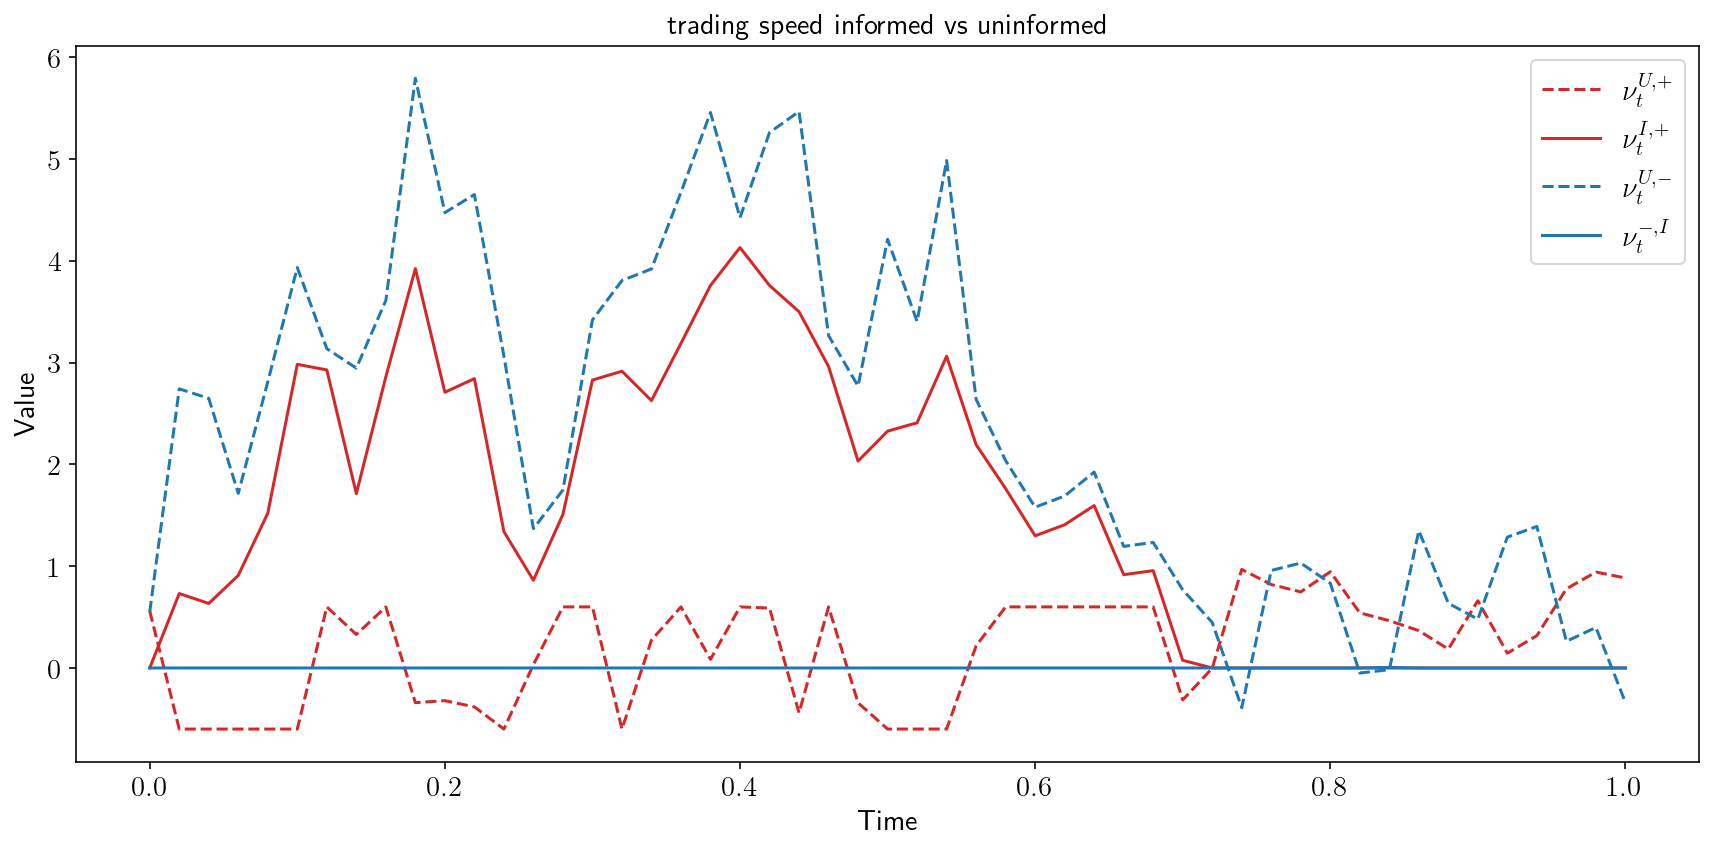

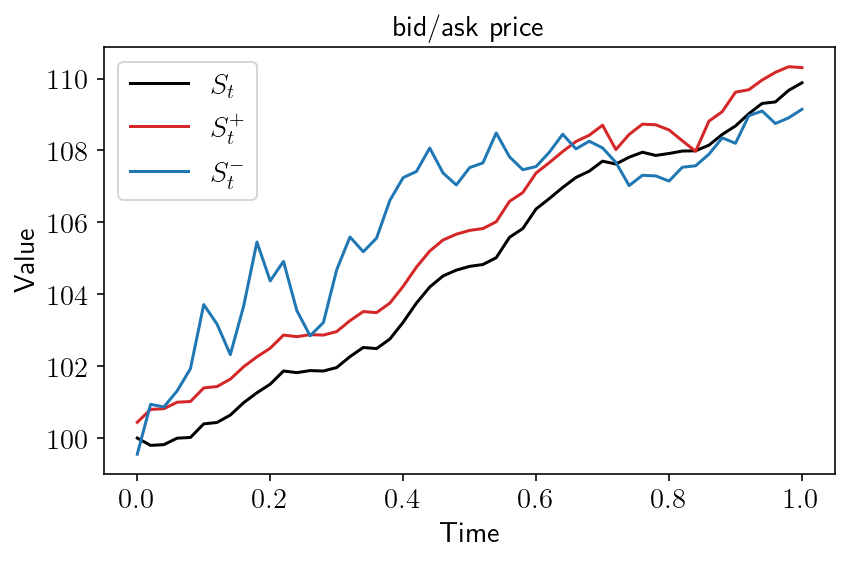

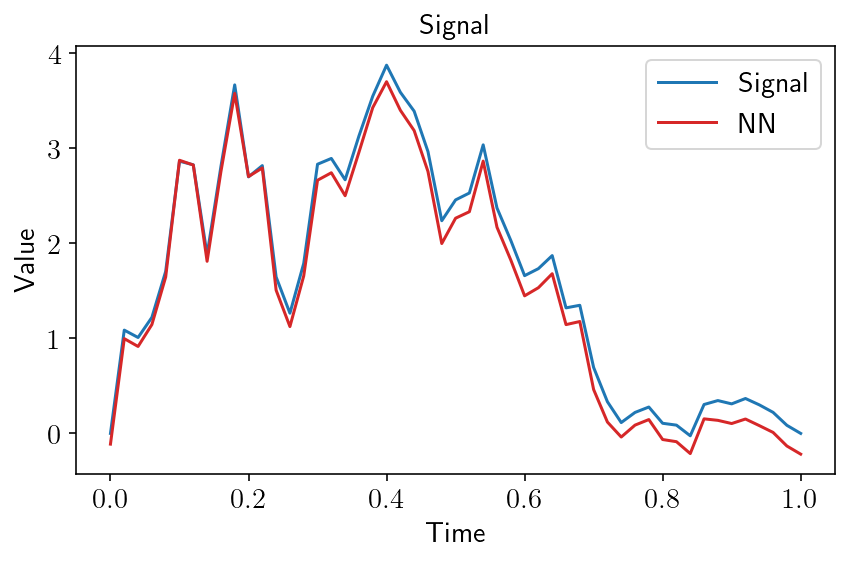

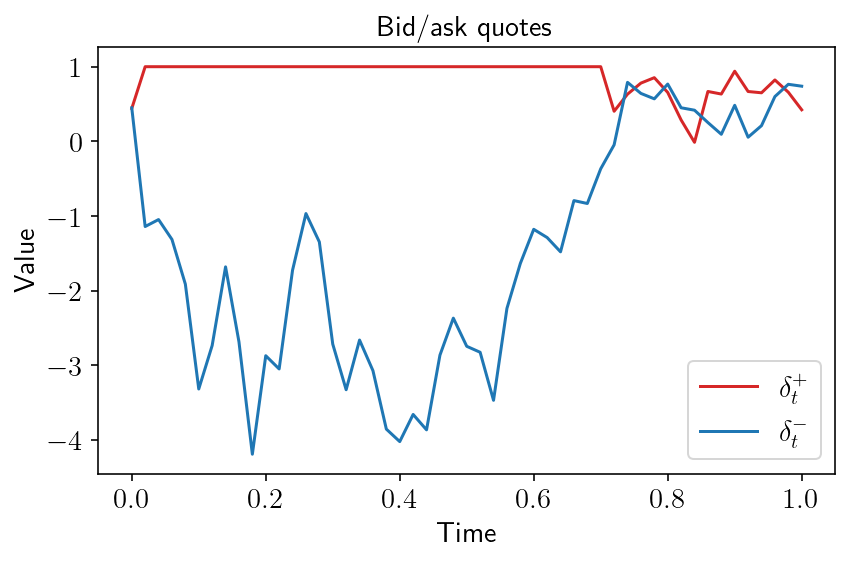

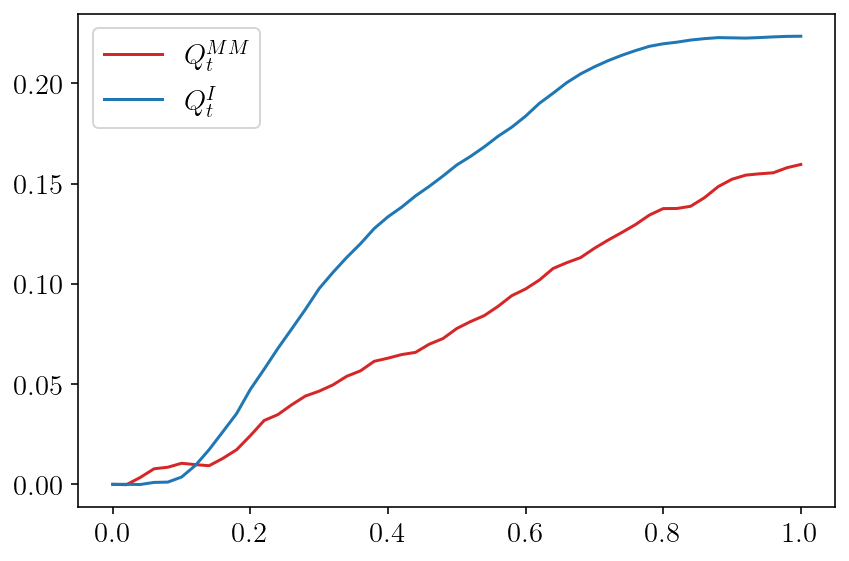

In [89]:
def plot_trajectory(Q_I, Q_M, Y_I, Y_M, alpha, Z_plus,Z_minus, T, N, dW_S, sample_idx=0,sample_size=sample):
    # Création d'un vecteur de temps
    time_grid = [i * T / N for i in range(N+1)]

    # Récupération des valeurs pour un élément spécifique du batch
    Q_I_vals = [Q_I[t][sample_idx].item() for t in range(N+1)]
    Q_M_vals = [Q_M[t][sample_idx].item() for t in range(N+1)]
    Y_I_vals = [Y_I[t][sample_idx].item() for t in range(N+1)]
    Y_M_vals = [Y_M[t][sample_idx].item() for t in range(N+1)]
    alpha_vals = [alpha[t][sample_idx].item() for t in range(N+1)]
    Z_plus_vals = [Z_plus[t][sample_idx].item() for t in range(N+1)]
    Z_minus_vals = [Z_minus[t][sample_idx].item() for t in range(N+1)]
    Q_M_mean = [torch.mean(Q_M[t]) for t in range(N+1)]
    Q_I_mean = [torch.mean(Q_I[t]) for t in range(N+1)]


    
    nu_plus = [nu_delta(Y_I_vals[t],Y_M_vals[t],Z_plus_vals[t],Z_minus_vals[t])[0] for t in range(N+1)]
    nu_minus = [nu_delta(Y_I_vals[t],Y_M_vals[t],Z_plus_vals[t],Z_minus_vals[t])[1] for t in range(N+1)]
    delta_plus = [nu_delta(Y_I_vals[t],Y_M_vals[t],Z_plus_vals[t],Z_minus_vals[t])[2] for t in range(N+1)]
    delta_minus = [nu_delta(Y_I_vals[t],Y_M_vals[t],Z_plus_vals[t],Z_minus_vals[t])[3] for t in range(N+1)]
    
    S_t = [100]
    for t in range(N):
        S_t.append(S_t[t] + alpha_vals[t]*(T / N) + dW_S[sample_idx,t,:])
    

    NN = [Y_I_vals[t]-k*beta*Y_M_vals[t] for t in range(N+1)]
    proj_alpha_compt = [(1-k*beta)*alpha_vals[t]*(1-np.exp(-eta_a*(T-time_grid[t])))/eta_a for t in range(N+1)]

    plt.figure(figsize=(12, 6))

    # Trajectoire pour Q_I et Q_M
    plt.plot(time_grid,[zeta - k*delta_plus[t]+Z_plus_vals[t] for t in range(len(delta_plus))],'--',label=r'$\nu_t^{U,+}$', color='tab:red')
    plt.plot(time_grid, nu_plus, label=r"$\nu_t^{I,+}$", color='tab:red')
    plt.plot(time_grid,[zeta - k*delta_minus[t]+Z_minus_vals[t] for t in range(len(delta_plus))],'--',label=r'$\nu_t^{U,-}$', color='tab:blue')
    plt.plot(time_grid, nu_minus, label=r"$\nu_t^{-,I}$", color='tab:blue')
    plt.title("trading speed informed vs uninformed")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    #plt.savefig('figures/nu_NN.pdf', dpi = 300, format = 'pdf')
    plt.show()
    
        
    plt.plot(time_grid,S_t,label=r'$S_t$',color='black')
    plt.plot(time_grid,np.array(S_t) + np.array(delta_plus),label=r'$S_t^+$', color='tab:red')
    plt.plot(time_grid,np.array(S_t) - np.array(delta_minus),label=r'$S_t^-$',color="tab:blue")
    plt.title("bid/ask price")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    #plt.savefig('figures/S_NN.pdf', dpi = 300, format = 'pdf')
    plt.show()

    
            
    plt.plot(time_grid,proj_alpha_compt,label='Signal',color='tab:blue')
    #plt.plot(time_grid,alpha_vals,label=r'$\alpha_t$',color='tab:red')
    plt.plot(time_grid,NN, label='NN',color='tab:red')
    plt.title("Signal")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    #plt.savefig('figures/signal_NN.pdf', dpi = 300, format = 'pdf')
    plt.show()

    
    
    plt.plot(time_grid, delta_plus, label=r"$\delta_t^+$", color='tab:red')
    plt.plot(time_grid, delta_minus, label=r"$\delta_t^-$", color='tab:blue')
    plt.title("Bid/ask quotes")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    #plt.savefig('figures/delta_NN.pdf', dpi = 300, format = 'pdf')
    plt.show()
    
    
    plt.plot(time_grid,Q_M_mean,label=r"$Q^{MM}_t$",color="tab:red")    
    plt.plot(time_grid,Q_I_mean,label=r"$Q^I_t$",color="tab:blue")
    plt.legend()
    plt.tight_layout()
    #plt.savefig('figures/Z_NN.pdf', dpi = 300, format = 'pdf')
    plt.show()

        
# Fonction principale pour récupérer les valeurs et afficher les courbes
def plot_after_training(sample_size=sample):
    dW_S = torch.randn(sample_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
    dW_A = torch.randn(sample_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
    dW_ZP = torch.randn(sample_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
    dW_ZM = torch.randn(sample_size, N, Y0_I.shape[1]) * (T / N) ** 0.5
    # Récupérer la trajectoire simulée après l'entraînement
    Q_I,Q_M, Y_I,Y_M,_,_,_,_,_,_,_,_,alpha,Z_plus,Z_minus = simulate_trajectory(
            Q0_I.expand(sample_size, -1), Q0_M.expand(sample_size,-1), Y0_I.expand(sample_size, -1), Y0_M.expand(sample_size, -1),Z_nets, b_QI,b_QM,b_YI,b_YM, T, N,  dW_S,dW_A,dW_ZP,dW_ZM)
    # Affichage des courbes pour le premier élément du batch
    plot_trajectory(Q_I, Q_M, Y_I, Y_M,alpha,Z_plus,Z_minus, T, N, dW_S, sample_idx=0,sample_size=sample)

# Appeler la fonction pour afficher les courbes après l'entraînement
plot_after_training()


In [90]:
def PnL(nb_it):
    dW_S = torch.randn(nb_it, N, Y0_I.shape[1]) * (T / N) ** 0.5
    dW_A = torch.randn(nb_it, N, Y0_I.shape[1]) * (T / N) ** 0.5
    dW_ZP = torch.randn(nb_it, N, Y0_I.shape[1]) * (T / N) ** 0.5
    dW_ZM = torch.randn(nb_it, N, Y0_I.shape[1]) * (T / N) ** 0.5
    # Récupérer la trajectoire simulée après l'entraînement
    Q_I,Q_M, Y_I,Y_M,_,_,_,_,_,_,_,_,alpha,Z_plus,Z_minus = simulate_trajectory(
            Q0_I.expand(nb_it, -1), Q0_M.expand(nb_it,-1), Y0_I.expand(nb_it, -1), Y0_M.expand(nb_it, -1),Z_nets, b_QI,b_QM,b_YI,b_YM, T, N,  dW_S,dW_A,dW_ZP,dW_ZM)
    X_I =  Q0_I.expand(nb_it, -1)
    X_U = Q0_I.expand(nb_it, -1)
    S = torch.tensor([100], dtype=torch.float32).expand(nb_it, -1)
    X_M = Q0_I.expand(nb_it, -1)
    Q_tot_I = Q0_I.expand(nb_it, -1)
    Q_tot_M = Q0_I.expand(nb_it, -1)
    Q_tot_U = Q0_I.expand(nb_it, -1)

    for t in range(N):
        nu_plus = nu(Y_I[t],Y_M[t],Z_plus[t],Z_minus[t])[0]
        nu_minus = nu(Y_I[t],Y_M[t],Z_plus[t],Z_minus[t])[1]
        delta_plus = delta(nu_plus,nu_minus,Z_plus[t],Z_minus[t],Y_M[t])[0]
        delta_minus = delta(nu_plus,nu_minus,Z_plus[t],Z_minus[t],Y_M[t])[1]

        nu_inf_plus = zeta - k*delta_plus + Z_plus[t]
        nu_inf_minus = zeta - k*delta_minus + Z_minus[t]

        X_I = X_I + (S - delta_minus - kappa_i*nu_minus)*nu_minus*dt - (S + delta_plus + kappa_i*nu_plus)*nu_plus*dt
        X_U = X_U + (S - delta_minus - kappa_u*nu_inf_minus)*nu_inf_minus*dt - (S + delta_plus + kappa_u*nu_inf_plus)*nu_inf_plus*dt
        X_M = (-1)*X_I +(-1)* X_U
        S = S +alpha[t]*dt + dW_S[:,t,:]
        
        Q_tot_I = Q_tot_I + Q_I[t]**2*dt
        Q_tot_M = Q_tot_M + Q_M[t]**2*dt
        Q_tot_U = Q_tot_U + (-Q_M[t]-Q_I[t])**2*dt
        
    data_I = (X_I + S*Q_I[-1]- alpha_I*Q_I[-1]**2-phi_I*Q_tot_I).detach().numpy()
    data_M = (X_M + S*Q_M[-1]- alpha_M*Q_M[-1]**2-phi_M*Q_tot_M).detach().numpy()
    data_U = (X_U + S*(-Q_M[-1]-Q_I[-1])- alpha_I*(-Q_M[-1]-Q_I[-1])**2-phi_I*Q_tot_U).detach().numpy()

    return data_I,data_M,data_U


In [91]:
torch.manual_seed(0)
data_I,data_M,data_U = PnL(100_000)
data_I = np.array(data_I)
data_M = np.array(data_M)
data_U = np.array(data_U)
mean_value_U = data_U.mean()
mean_value_I = data_I.mean()
mean_value_M = data_M.mean()

In [94]:
def plot_combined_histograms(pnl_i, pnl_m, pnl_u):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    # Informed trader
    mean_i = pnl_i.mean()
    axes[0].hist(pnl_i, bins=30, alpha=0.6, color='blue', label='Informed trader')
    axes[0].axvline(mean_i, color='red', linestyle='--', linewidth=2, label='Mean')
    axes[0].set_title(f'Informed trader\nMean = {mean_i:.4f}')
    axes[0].set_xlabel('Adjusted PnL')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()

    # Market maker
    mean_m = pnl_m.mean()
    axes[1].hist(pnl_m, bins=30, alpha=0.6, color='green', label='Market maker')
    axes[1].axvline(mean_m, color='red', linestyle='--', linewidth=2, label='Mean')
    axes[1].set_title(f'Market maker\nMean = {mean_m:.4f}')
    axes[1].set_xlabel('Adjusted PnL')
    axes[1].legend()

    # Uninformed trader
    mean_u = pnl_u.mean()
    axes[2].hist(pnl_u, bins=30, alpha=0.6, color='orange', label='Uninformed trader')
    axes[2].axvline(mean_u, color='red', linestyle='--', linewidth=2, label='Mean')
    axes[2].set_title(f'Uninformed trader\nMean = {mean_u:.4f}')
    axes[2].set_xlabel('Adjusted PnL')
    axes[2].legend()

    plt.suptitle('Histograms of Adjusted PnL by Trader Type', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('figures/combined_histogram_subplots_big_alpha_phiM_1_NN.pdf', dpi=300, format='pdf')
    plt.show()


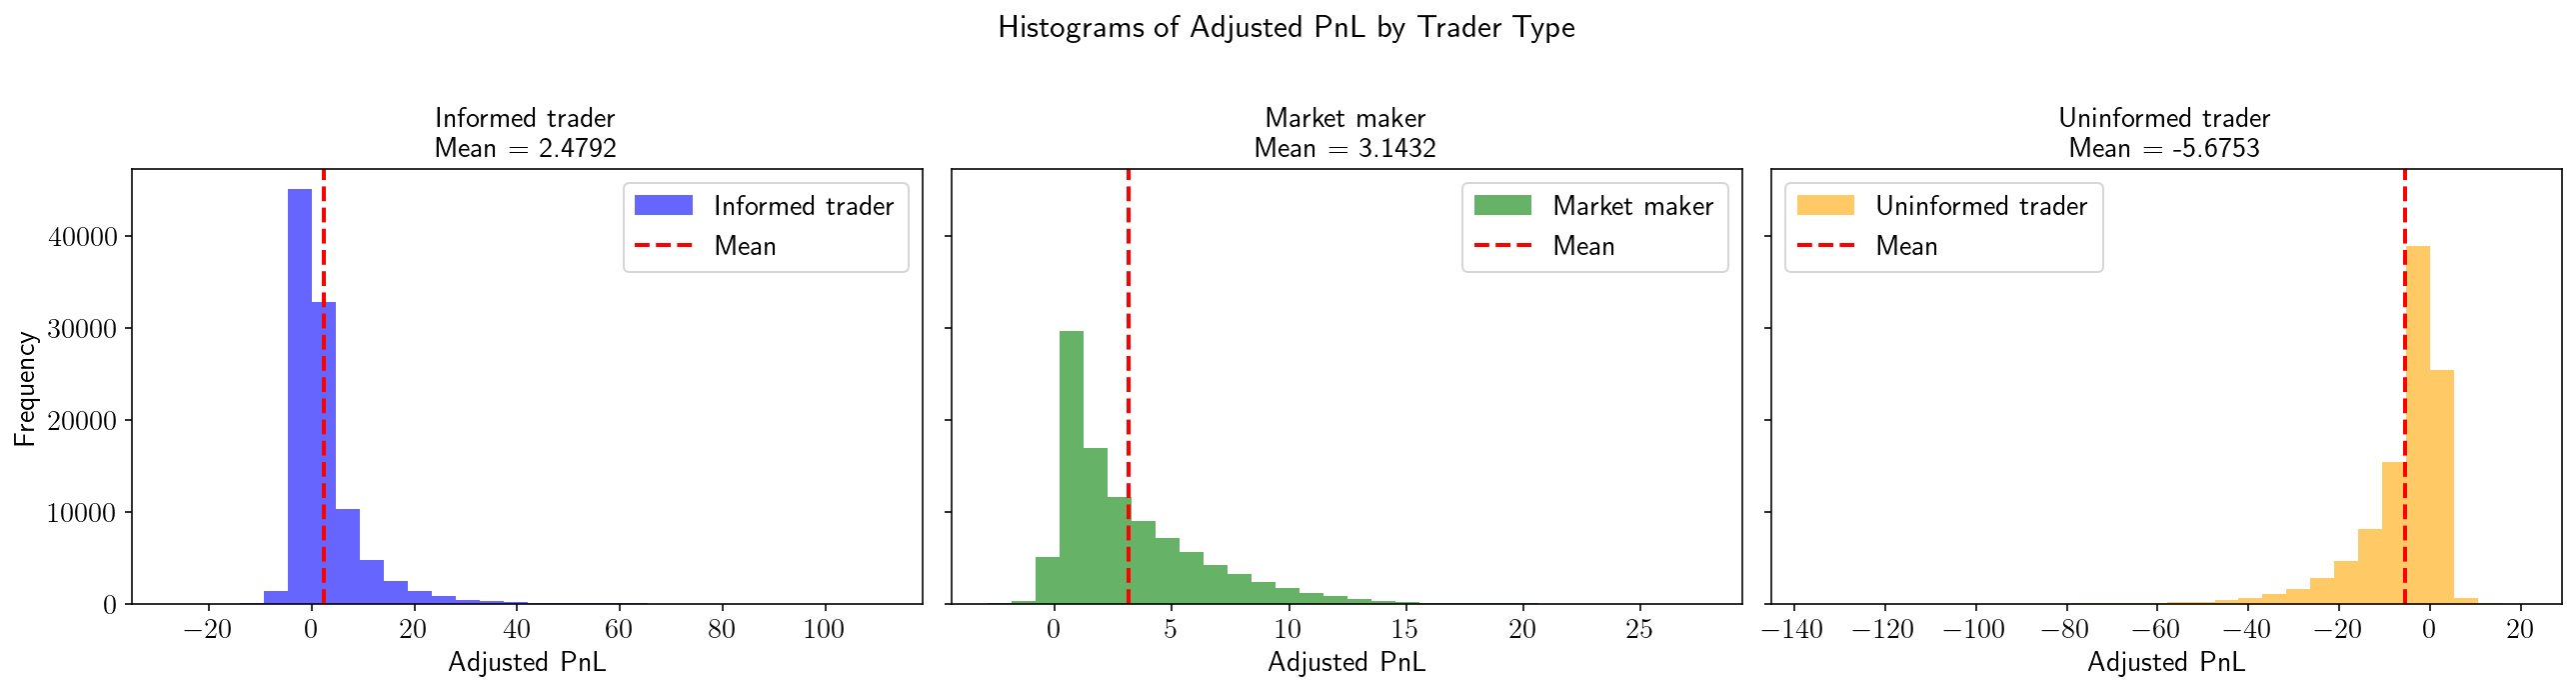

None


In [95]:
print(plot_combined_histograms(data_I,data_M,data_U ))

# Case where $\phi^{i,M} =\alpha^{I,M} = 0$

In [63]:
def comput():
    time = [i * T / N for i in range(N+1)]
    alpha = np.zeros(N)
    X_I = np.zeros(N)
    X_U = np.zeros(N)
    X_M = np.zeros(N)
    Q_I = np.zeros(N)
    Q_U = np.zeros(N)
    Q_M = np.zeros(N)
    Q_tot_I = np.zeros(N)
    Q_tot_U = np.zeros(N)
    Q_tot_M = np.zeros(N)
    Z_t_plus = np.zeros(N)
    Z_t_minus = np.zeros(N)
    esp_alpha = np.zeros(N)
    
    for t in range(N-1):
        alpha[t+1] = alpha[t] -eta_a *alpha[t]*dt + sigma_a * np.random.normal(0,1,1)*np.sqrt(dt)

   
    for t in range(N-1):
        Z_t_plus[t+1] = Z_t_plus[t] -eta_ZP *Z_t_plus[t]*dt + sigma_ZP * np.random.normal(0,1,1)*np.sqrt(dt)
        Z_t_plus[t+1] = max(-Z_bound,min(Z_bound,Z_t_plus[t+1]))
        Z_t_minus[t+1] = Z_t_minus[t] -eta_ZM *Z_t_minus[t]*dt + sigma_ZM * np.random.normal(0,1,1)*np.sqrt(dt)
        Z_t_minus[t+1] = max(-Z_bound,min(Z_bound,Z_t_minus[t+1]))

  
    for t in range(N):
        esp_alpha[t] =  alpha[t]*(1-np.exp(-eta_a*(T-time[t])))/eta_a

    n_iter = 50
    nu_plus=np.zeros(N)
    nu_minus = np.zeros(N)
    delta_plus = np.zeros(N)
    delta_minus = np.zeros(N)
    
    for n in  range(n_iter):
        NP = nu_plus.copy()
        NM = nu_minus.copy()
        for t in range(N):
            nu_plus[t] = 1/(2*kappa_i) * max((-delta_plus[t] + alpha[t]*(1-np.exp(-eta_a*(T-time[t])))/eta_a),0)
            nu_minus[t] = 1/(2*kappa_i) * max((-delta_minus[t] - alpha[t]*(1-np.exp(-eta_a*(T-time[t])))/eta_a),0)

            delta_plus[t] = (min((zeta)/k,beta*(NP[t]*f_i + (1-2*k*kappa_u*f_u)*(zeta+Z_t_plus[t]) + k*alpha[t]*(1-np.exp(-eta_a*(T-time[t])))/eta_a)))
            delta_minus[t] = (min((zeta)/k,beta*(NM[t]*f_i + (1-2*k*kappa_u*f_u)*(zeta+Z_t_minus[t]) - k*alpha[t]*(1-np.exp(-eta_a*(T-time[t])))/eta_a)))


    nu_U_plus = []
    nu_U_minus=[]
    for t in range(N):
        nu_U_plus.append(zeta-k*delta_plus[t]+Z_t_plus[t])
        nu_U_minus.append(zeta-k*delta_minus[t] + Z_t_minus[t])

    S_t = np.zeros(N)
    S_t_plus = np.zeros(N)
    S_t_minus = np.zeros(N)

    S_t[0] = S0
    S_t_plus[0] = S_t[0] + delta_plus[0]
    S_t_minus[0] = S_t[0] - delta_minus[0]
    for t in range(N-1):
        S_t[t+1] = S_t[t] + alpha[t]*dt + np.random.normal(0,1,1)*np.sqrt(dt)
        S_t_plus[t+1] = S_t[t+1] + delta_plus[t+1]
        S_t_minus[t+1] = S_t[t+1] -delta_minus[t+1]
        X_I[t+1] = X_I[t] + (S_t_minus[t]-kappa_i*nu_minus[t])*nu_minus[t]*dt - (S_t_plus[t]+kappa_i*nu_plus[t])*nu_plus[t]*dt
        X_U[t+1] = X_U[t] + (S_t_minus[t]-kappa_u*nu_U_minus[t])*nu_U_minus[t]*dt - (S_t_plus[t]+kappa_u*nu_U_plus[t])*nu_U_plus[t]*dt
        X_M[t+1] = -f_i*X_I[t+1]-f_u*X_U[t+1]
        Q_I[t+1] = Q_I[t] + (nu_plus[t]-nu_minus[t])*dt
        Q_U[t+1] = Q_U[t] + (nu_U_plus[t]-nu_U_minus[t])*dt
        Q_M[t+1] = -f_i*Q_I[t] - f_u*Q_U[t]
        Q_tot_I[t+1] = Q_tot_I[t] + Q_I[t]**2*dt
        Q_tot_U[t+1] = Q_tot_U[t] + Q_U[t]**2*dt
        Q_tot_M[t+1] = Q_tot_M[t] + Q_M[t]**2*dt


    
    return nu_plus,nu_minus,delta_plus,delta_minus,S_t,Q_I,Q_M,Q_U,X_I,X_M,X_U,Q_tot_I,Q_tot_M,Q_tot_U,Z_t_plus,Z_t_minus


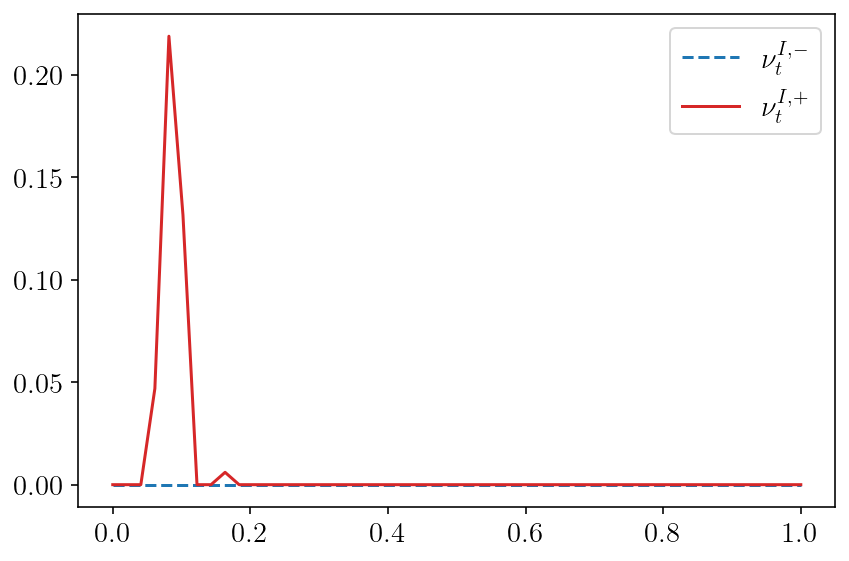

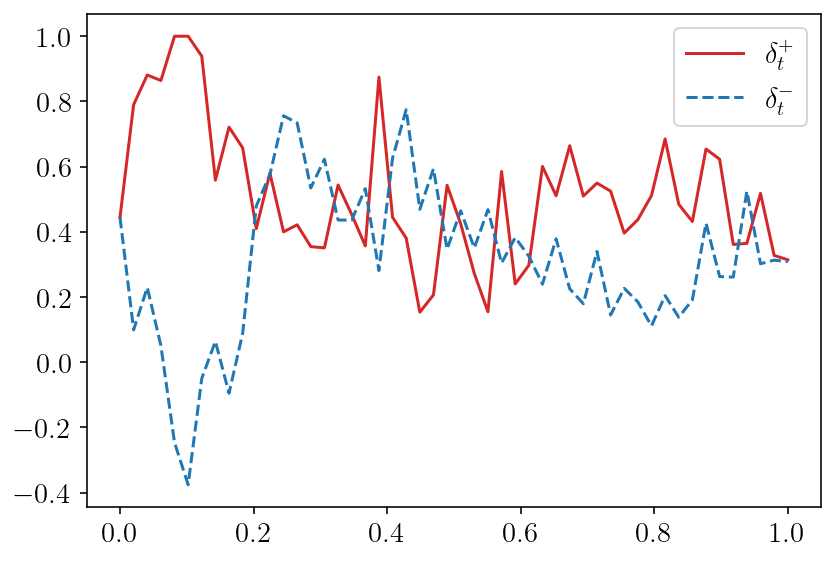

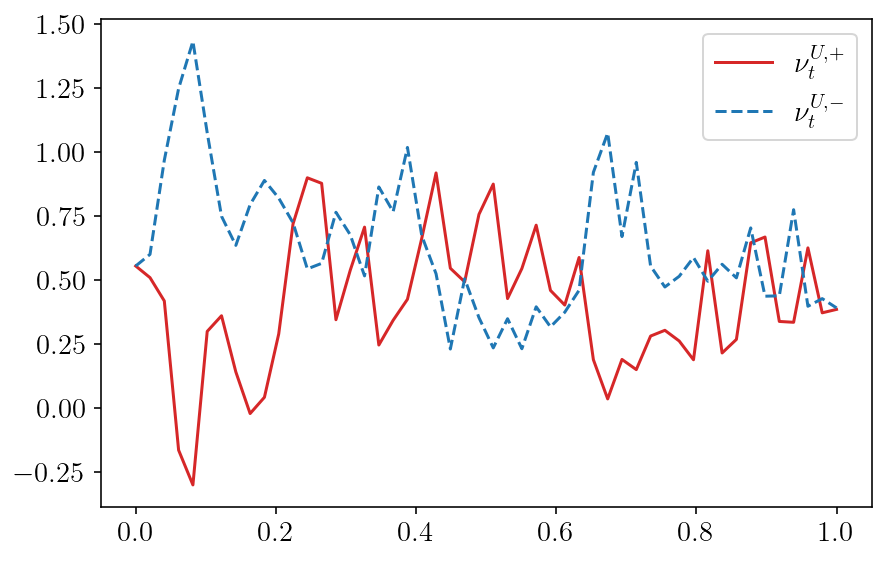

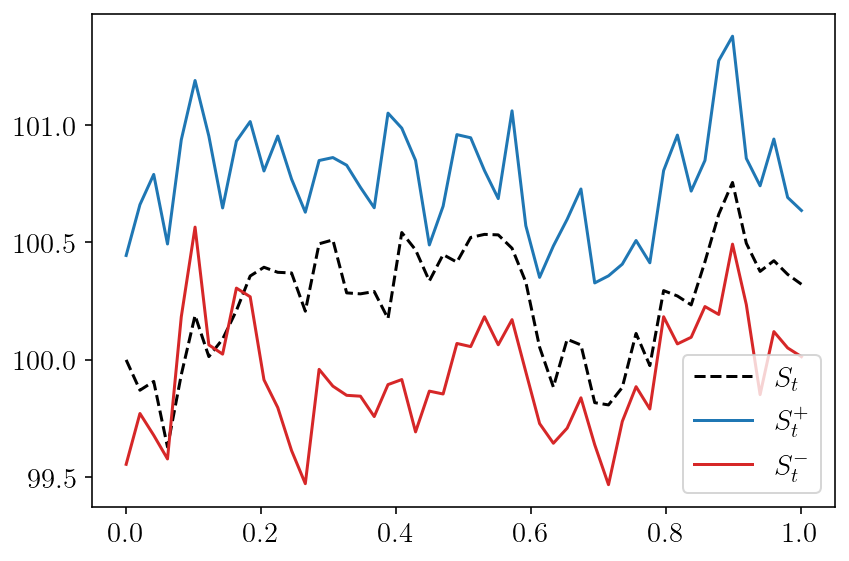

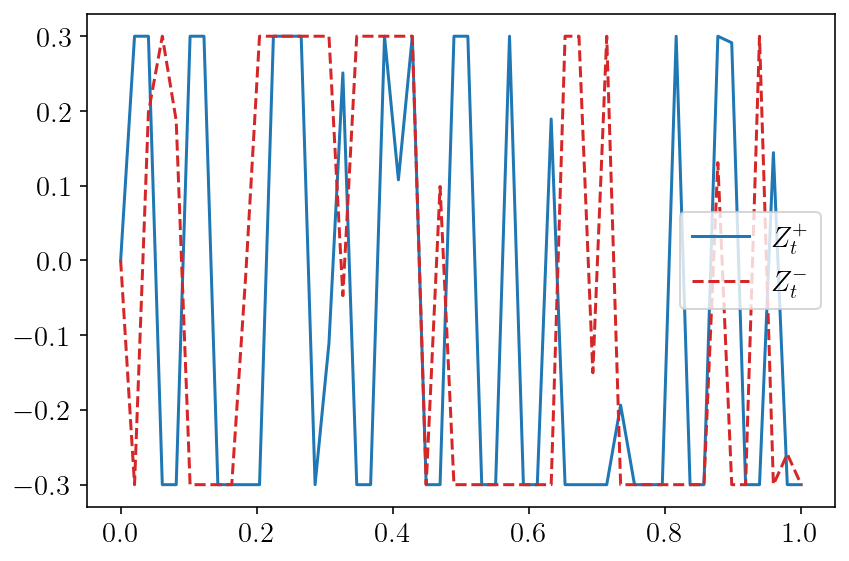

In [29]:
time = np.linspace(0,T,N)
nu_plus,nu_minus,delta_plus,delta_minus,S_t,_,_,_,_,_,_,_,_,_,Z_t_plus,Z_t_minus = comput()
nu_U_plus = zeta*np.ones(N) - k*delta_plus + Z_t_plus
nu_U_minus = zeta*np.ones(N) - k*delta_minus + Z_t_minus
S_t_plus = S_t + delta_plus
S_t_minus = S_t - delta_minus


plt.plot(time,nu_minus,'--', label=r'$\nu_t^{I,-}$',color ='tab:blue')
plt.plot(time,nu_plus, label=r'$\nu_t^{I,+}$',color ='tab:red')
plt.legend()
plt.tight_layout()
plt.savefig('figures/nu_I.pdf', dpi = 300, format = 'pdf')
plt.show()

plt.plot(time,delta_plus,label=r'$\delta_t^{+}$',color ='tab:red')
plt.plot(time,delta_minus,'--', label=r'$\delta_t^{-}$',color ='tab:blue')
plt.legend()
plt.tight_layout()
plt.savefig('figures/delta.pdf', dpi = 300, format = 'pdf')
plt.show()

plt.plot(time,nu_U_plus, label=r'$\nu_t^{U,+}$',color ='tab:red')
plt.plot(time,nu_U_minus,'--', label=r'$\nu_t^{U,-}$',color ='tab:blue')
plt.legend()
plt.tight_layout()
plt.savefig('figures/nu_U.pdf', dpi = 300, format = 'pdf')
plt.show()
    

plt.plot(time,S_t,'--',label=r'$S_t$',color ='black')
plt.plot(time,S_t_plus,label=r'$S_t^+$',color ='tab:blue')
plt.plot(time,S_t_minus,label=r'$S_t^-$',color ='tab:red')
plt.legend()
plt.tight_layout()
plt.savefig('figures/S.pdf', dpi = 300, format = 'pdf')
plt.show()

plt.plot(time,Z_t_plus,label=r'$Z_t^+$', color ='tab:blue')
plt.plot(time,Z_t_minus,'--', label=r'$Z_t^-$', color ='tab:red')
plt.legend()
plt.tight_layout()
plt.savefig('figures/Z.pdf', dpi = 300, format = 'pdf')
plt.show()

In [26]:
def comput_and_PnL_hist(nb_iter):
    sqrt_dt = torch.sqrt(torch.tensor(dt))
    eps = torch.rand(nb_iter,N)
    esp_alpha_delta = torch.rand(nb_iter,N)
    eps_val = 0
    eps_val_nu = 0

    alpha = torch.zeros((nb_iter, N))
    Z_t_plus = torch.zeros((nb_iter, N))
    Z_t_minus = torch.zeros((nb_iter, N))
    S_t = torch.zeros((nb_iter, N))
    esp_alpha = torch.zeros((nb_iter, N))

    nu_plus = torch.zeros((nb_iter, N))
    nu_minus = torch.zeros((nb_iter, N))
    delta_plus = torch.zeros((nb_iter, N))
    delta_minus = torch.zeros((nb_iter, N))

    X_I = torch.zeros((nb_iter, N))
    X_U = torch.zeros((nb_iter, N))
    X_M = torch.zeros((nb_iter, N))
    Q_I = torch.zeros((nb_iter, N))
    Q_U = torch.zeros((nb_iter, N))
    Q_M = torch.zeros((nb_iter, N))
    Q_tot_I = torch.zeros((nb_iter, N))
    Q_tot_U = torch.zeros((nb_iter, N))
    Q_tot_M = torch.zeros((nb_iter, N))

    noise_alpha = torch.randn(nb_iter, N)
    noise_ZP = torch.randn(nb_iter, N)
    noise_ZM = torch.randn(nb_iter, N)
    noise_S = torch.randn(nb_iter, N)

    time = torch.linspace(0, T, N)

    for t in range(N - 1):
        alpha[:, t+1] = alpha[:, t] - eta_a * alpha[:, t] * dt + sigma_a * noise_alpha[:, t] * sqrt_dt
        Z_t_plus[:, t+1] = Z_t_plus[:, t] - eta_ZP * Z_t_plus[:, t] * dt + sigma_ZP * noise_ZP[:, t] * sqrt_dt
        Z_t_plus[:, t+1] = torch.clamp(Z_t_plus[:, t+1], -Z_bound, Z_bound)
        Z_t_minus[:, t+1] = Z_t_minus[:, t] - eta_ZM * Z_t_minus[:, t] * dt + sigma_ZM * noise_ZM[:, t] * sqrt_dt
        Z_t_minus[:, t+1] = torch.clamp(Z_t_minus[:, t+1], -Z_bound, Z_bound)

    for t in range(N):
        esp_alpha[:, t] = alpha[:, t] * (1 - torch.exp(-eta_a * (T - time[t]))) / eta_a + eps_val_nu*(T-time[t])*eps[:,t]
        esp_alpha_delta[:, t] = alpha[:, t] * (1 - torch.exp(-eta_a * (T - time[t]))) / eta_a  + eps_val*(T-time[t])*eps[:,t]



    n_iter = 50
    for _ in range(n_iter):
        NP = nu_plus.clone()
        NM = nu_minus.clone()
        expr_plus = -delta_plus + esp_alpha
        expr_minus = -delta_minus - esp_alpha
        nu_plus = torch.clamp(expr_plus / (2 * kappa_i), min=0)
        nu_minus = torch.clamp(expr_minus / (2 * kappa_i), min=0)

        delta_plus = torch.min(
            torch.full_like(nu_plus, zeta / k),
            beta * (f_i*NP + (1 - 2 * k * kappa_u*f_u) * (zeta + Z_t_plus)+ k * esp_alpha_delta )
        )
        delta_minus = torch.min(
            torch.full_like(nu_minus, zeta / k),
            beta * (f_i*NM + (1 - 2 * k * kappa_u*f_u) * (zeta + Z_t_minus)-k *esp_alpha_delta)
        )

    nu_U_plus = zeta - k * delta_plus + Z_t_plus
    nu_U_minus = zeta - k * delta_minus + Z_t_minus

    S_t[:, 0] = S0
    S_t_plus = S_t + delta_plus
    S_t_minus = S_t - delta_minus

    for t in range(N - 1):
        S_t[:, t+1] = S_t[:, t] + alpha[:, t] * dt + noise_S[:, t] * sqrt_dt
        S_t_plus[:, t+1] = S_t[:, t+1] + delta_plus[:, t+1]
        S_t_minus[:, t+1] = S_t[:, t+1] - delta_minus[:, t+1]

        X_I[:, t+1] = X_I[:, t] + (S_t_minus[:, t] - kappa_i * nu_minus[:, t]) * nu_minus[:, t] * dt - (S_t_plus[:, t] + kappa_i * nu_plus[:, t]) * nu_plus[:, t] * dt
        X_U[:, t+1] = X_U[:, t] + (S_t_minus[:, t] - kappa_u * nu_U_minus[:, t]) * nu_U_minus[:, t] * dt - (S_t_plus[:, t] + kappa_u * nu_U_plus[:, t]) * nu_U_plus[:, t] * dt
        X_M[:, t+1] = -f_i*X_I[:, t+1] - f_u*X_U[:, t+1]

        Q_I[:, t+1] = Q_I[:, t] + (nu_plus[:, t] - nu_minus[:, t]) * dt
        Q_U[:, t+1] = Q_U[:, t] + (nu_U_plus[:, t] - nu_U_minus[:, t]) * dt
        Q_M[:, t+1] = -f_i*Q_I[:, t+1] - f_u*Q_U[:, t+1]

        Q_tot_I[:, t+1] = Q_tot_I[:, t] + Q_I[:, t]**2 * dt
        Q_tot_U[:, t+1] = Q_tot_U[:, t] + Q_U[:, t]**2 * dt
        Q_tot_M[:, t+1] = Q_tot_M[:, t] + Q_M[:, t]**2 * dt

    QSI = S_t[:, -1] * Q_I[:, -1]
    QSM = S_t[:, -1] * Q_M[:, -1]
    QSU = S_t[:, -1] * Q_U[:, -1]

    Q_Is = Q_I[:, -1]**2
    Q_Ms = Q_M[:, -1]**2
    Q_Us = Q_U[:, -1]**2

    PnL_I =  (X_I[:, -1] + QSI - alpha_I * Q_Is - phi_I * Q_tot_I[:, -1])
    PnL_M =  (X_M[:, -1] + QSM - alpha_M * Q_Ms - phi_M * Q_tot_M[:, -1])
    PnL_U =  (X_U[:, -1] + QSU - alpha_I * Q_Us - phi_I * Q_tot_U[:, -1])

    pnl_i = PnL_I.detach().cpu().numpy()
    pnl_m = PnL_M.detach().cpu().numpy()
    pnl_u = PnL_U.detach().cpu().numpy()


    return pnl_i, pnl_m, pnl_u


In [27]:
def plot_combined_histograms(pnl_i, pnl_m, pnl_u):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    # Informed trader
    mean_i = pnl_i.mean()
    axes[0].hist(pnl_i, bins=30, alpha=0.6, color='blue', label='Informed trader')
    axes[0].axvline(mean_i, color='red', linestyle='--', linewidth=2, label='Mean')
    axes[0].set_title(f'Informed trader\nMean = {mean_i:.4f}')
    axes[0].set_xlabel('Adjusted PnL')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()

    # Market maker
    mean_m = pnl_m.mean()
    axes[1].hist(pnl_m, bins=30, alpha=0.6, color='green', label='Market maker')
    axes[1].axvline(mean_m, color='red', linestyle='--', linewidth=2, label='Mean')
    axes[1].set_title(f'Market maker\nMean = {mean_m:.4f}')
    axes[1].set_xlabel('Adjusted PnL')
    axes[1].legend()

    # Uninformed trader
    mean_u = pnl_u.mean()
    axes[2].hist(pnl_u, bins=30, alpha=0.6, color='orange', label='Uninformed trader')
    axes[2].axvline(mean_u, color='red', linestyle='--', linewidth=2, label='Mean')
    axes[2].set_title(f'Uninformed trader\nMean = {mean_u:.4f}')
    axes[2].set_xlabel('Adjusted PnL')
    axes[2].legend()

    plt.suptitle('Histograms of Adjusted PnL by Trader Type', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    #plt.savefig('figures/combined_histogram_subplots_kappa_inf.pdf', dpi=300, format='pdf')
    plt.show()


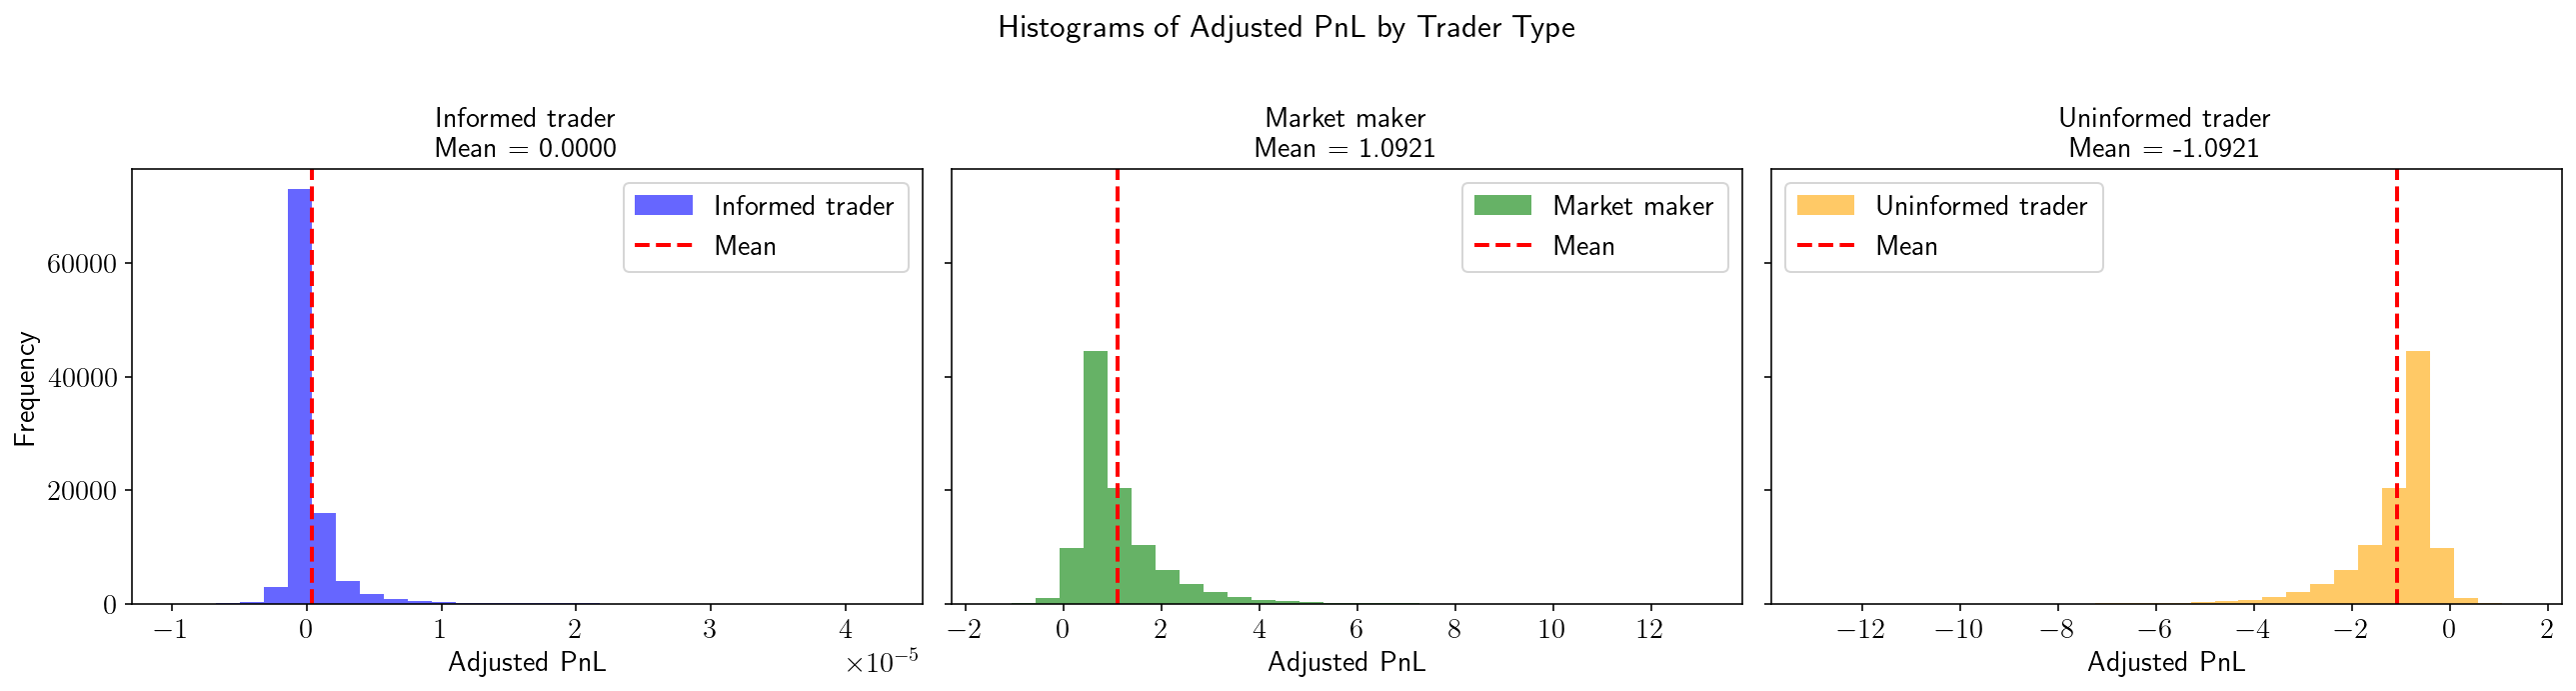

None


In [28]:
torch.manual_seed(0)
pnl_i, pnl_m, pnl_u = comput_and_PnL_hist(nb_iter=100_000)
print(plot_combined_histograms(pnl_i,pnl_m,pnl_u))